<center><h1>Lewis_Rylan_Nathan_HW8</h1></center>

Dear TA, I am using my Late days for this assignment. The deadline for this assignment was December 1st 11:59 pm, I am submitting it on December 3rd. Thank You.

Name: Rylan Nathan Lewis
<br>
Github Username: Rylannat
<br>
USC ID: 8358130873

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

Import packages

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [3]:
feature_names = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean",
    "smoothness_mean", "compactness_mean", "concavity_mean",
    "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",

    "radius_se", "texture_se", "perimeter_se", "area_se",
    "smoothness_se", "compactness_se", "concavity_se",
    "concave_points_se", "symmetry_se", "fractal_dimension_se",

    "radius_worst", "texture_worst", "perimeter_worst", "area_worst",
    "smoothness_worst", "compactness_worst", "concavity_worst",
    "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]

df = pd.read_csv("../data/wdbc.data", header=None)

df.columns = ["id", "diagnosis"] + feature_names

X = df[feature_names].values
y = (df["diagnosis"] == "M").astype(int).values


### (b) Monte-Carlo Simulation

In [4]:
M = 30

metrics_sup = {
    "train_acc_sup": [], "test_acc_sup": [],
    "train_prec_sup": [], "test_prec_sup": [],
    "train_rec_sup": [], "test_rec_sup": [],
    "train_f1_sup": [], "test_f1_sup": [],
    "train_auc_sup": [], "test_auc_sup": []
}


#### (i) Supervised Learning

In [5]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(penalty="l1", dual=False, max_iter=5000))
])

param_grid = {"svm__C": np.logspace(-3, 2, 10)}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [6]:
for run in range(M):
    print(f"Run {run+1}/{M}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=run
    )

    grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    y_train_score = best_model.decision_function(X_train)
    y_test_score = best_model.decision_function(X_test)

    metrics_sup["train_acc_sup"].append(accuracy_score(y_train, y_train_pred))
    metrics_sup["test_acc_sup"].append(accuracy_score(y_test, y_test_pred))

    metrics_sup["train_prec_sup"].append(precision_score(y_train, y_train_pred))
    metrics_sup["test_prec_sup"].append(precision_score(y_test, y_test_pred))

    metrics_sup["train_rec_sup"].append(recall_score(y_train, y_train_pred))
    metrics_sup["test_rec_sup"].append(recall_score(y_test, y_test_pred))

    metrics_sup["train_f1_sup"].append(f1_score(y_train, y_train_pred))
    metrics_sup["test_f1_sup"].append(f1_score(y_test, y_test_pred))

    metrics_sup["train_auc_sup"].append(roc_auc_score(y_train, y_train_score))
    metrics_sup["test_auc_sup"].append(roc_auc_score(y_test, y_test_score))


Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14/30
Run 15/30
Run 16/30
Run 17/30
Run 18/30
Run 19/30
Run 20/30
Run 21/30
Run 22/30
Run 23/30
Run 24/30
Run 25/30
Run 26/30
Run 27/30
Run 28/30
Run 29/30
Run 30/30


In [7]:
print("Average metrics over 30 runs for the supervised algorithm:")
for k in metrics_sup:
    print(f"{k}: {np.mean(metrics_sup[k]):.4f}")

Average metrics over 30 runs for the supervised algorithm:
train_acc_sup: 0.9849
test_acc_sup: 0.9637
train_prec_sup: 0.9908
test_prec_sup: 0.9648
train_rec_sup: 0.9686
test_rec_sup: 0.9365
train_f1_sup: 0.9796
test_f1_sup: 0.9500
train_auc_sup: 0.9968
test_auc_sup: 0.9927


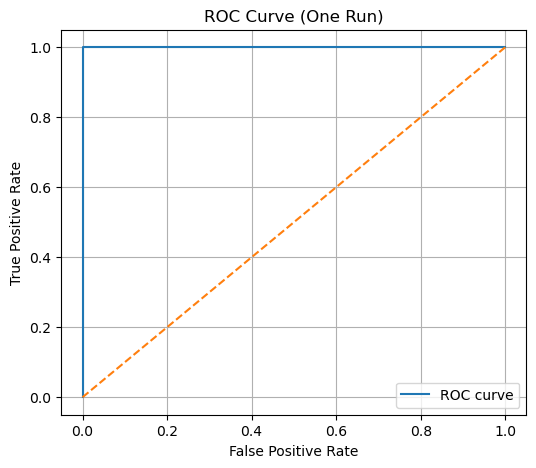


Confusion Matrix (Training):
[[283   2]
 [  5 165]]

Confusion Matrix (Test):
[[72  0]
 [ 1 41]]


In [8]:
fpr, tpr, _ = roc_curve(y_test, y_test_score)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One Run)")
plt.grid(True)
plt.legend()
plt.show()

print("\nConfusion Matrix (Training):")
print(confusion_matrix(y_train, y_train_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))


#### (ii) Semi-Supervised Learning/ Self-training

##### (A)

In [9]:
def train_l1_svm(X_lab, y_lab, cv_folds=5):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", LinearSVC(penalty="l1", dual=False, max_iter=5000))
    ])
    
    param_grid = {"svm__C": np.logspace(-3, 3, 7)}
    
    gs = GridSearchCV(pipe, param_grid, cv=cv_folds, scoring="accuracy", n_jobs=-1)
    gs.fit(X_lab, y_lab)
    
    return gs.best_estimator_

cv_folds = 5

metrics_semi = {
    "train_acc_semi": [], "test_acc_semi": [],
    "train_prec_semi": [], "test_prec_semi": [],
    "train_rec_semi": [], "test_rec_semi": [],
    "train_f1_semi": [], "test_f1_semi": [],
    "train_auc_semi": [], "test_auc_semi": []
}

rng = np.random.default_rng(42)


for run in range(M):
    print(f"RUN {run+1}/{M}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=run
    )

    pos_idx = np.where(y_train == 1)[0]
    neg_idx = np.where(y_train == 0)[0]

    labeled_pos = rng.choice(pos_idx, size=len(pos_idx) // 2, replace=False)
    labeled_neg = rng.choice(neg_idx, size=len(neg_idx) // 2, replace=False)

    labeled_idx = np.concatenate([labeled_pos, labeled_neg])

    X_labeled = X_train[labeled_idx]
    y_labeled = y_train[labeled_idx]

    model_semi = train_l1_svm(X_labeled, y_labeled, cv_folds)

RUN 1/30
RUN 2/30
RUN 3/30
RUN 4/30
RUN 5/30
RUN 6/30
RUN 7/30
RUN 8/30
RUN 9/30
RUN 10/30
RUN 11/30
RUN 12/30
RUN 13/30
RUN 14/30
RUN 15/30
RUN 16/30
RUN 17/30
RUN 18/30
RUN 19/30
RUN 20/30
RUN 21/30
RUN 22/30
RUN 23/30
RUN 24/30
RUN 25/30
RUN 26/30
RUN 27/30
RUN 28/30
RUN 29/30
RUN 30/30


##### (B)

In [10]:
    all_idx = np.arange(len(X_train))
    unlabeled_idx = np.setdiff1d(all_idx, labeled_idx)
    X_unlabeled = X_train[unlabeled_idx]

    X_lab = X_labeled.copy()
    y_lab = y_labeled.copy()
    remaining_unlabeled = X_unlabeled.copy()

    model = model_semi

    while len(remaining_unlabeled) > 0:
        distances = np.abs(model.decision_function(remaining_unlabeled))
        idx_farthest = np.argmax(distances)

        x_star = remaining_unlabeled[idx_farthest].reshape(1, -1)
        pseudo_label = model.predict(x_star)[0]

        X_lab = np.vstack([X_lab, x_star])
        y_lab = np.append(y_lab, pseudo_label)

        remaining_unlabeled = np.delete(remaining_unlabeled, idx_farthest, axis=0)

        model = train_l1_svm(X_lab, y_lab, cv_folds)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    y_score_train = model.decision_function(X_train)
    y_score_test = model.decision_function(X_test)

    metrics_semi["train_acc_semi"].append(accuracy_score(y_train, y_pred_train))
    metrics_semi["test_acc_semi"].append(accuracy_score(y_test, y_pred_test))

    metrics_semi["train_prec_semi"].append(precision_score(y_train, y_pred_train))
    metrics_semi["test_prec_semi"].append(precision_score(y_test, y_pred_test))

    metrics_semi["train_rec_semi"].append(recall_score(y_train, y_pred_train))
    metrics_semi["test_rec_semi"].append(recall_score(y_test, y_pred_test))

    metrics_semi["train_f1_semi"].append(f1_score(y_train, y_pred_train))
    metrics_semi["test_f1_semi"].append(f1_score(y_test, y_pred_test))

    metrics_semi["train_auc_semi"].append(roc_auc_score(y_train, y_score_train))
    metrics_semi["test_auc_semi"].append(roc_auc_score(y_test, y_score_test))

Average metrics over 30 runs for the semi supervised algorithm
train_acc_semi: 0.9714
test_acc_semi: 0.9825
train_prec_semi: 0.9758
test_prec_semi: 0.9762
train_rec_semi: 0.9471
test_rec_semi: 0.9762
train_f1_semi: 0.9612
test_f1_semi: 0.9762
train_auc_semi: 0.9946
test_auc_semi: 0.9997

CONFUSION MATRICES (LAST RUN)
Training:
[[281   4]
 [  9 161]]

Testing:
[[71  1]
 [ 1 41]]


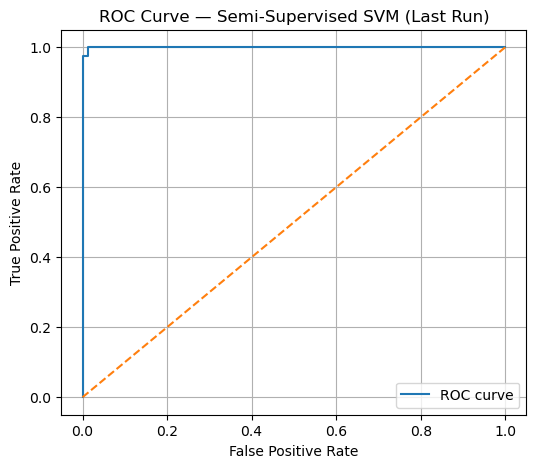

In [11]:
print("Average metrics over 30 runs for the semi supervised algorithm")
for k in metrics_semi:
    print(f"{k}: {np.mean(metrics_semi[k]):.4f}")

print("\nCONFUSION MATRICES (LAST RUN)")
print("Training:")
print(confusion_matrix(y_train, y_pred_train))
print("\nTesting:")
print(confusion_matrix(y_test, y_pred_test))

fpr, tpr, _ = roc_curve(y_test, y_score_test)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Semi-Supervised SVM (Last Run)")
plt.grid(True)
plt.legend()
plt.show()

#### (iii) Unsupervised Learning

##### (A)

In [12]:
num_kmeans_runs = 20    
k = 2                   

all_best_centers = []
all_best_labels = []
all_best_inertia = []

for mc_run in range(M):
    print(f"\nMonte-Carlo Run {mc_run+1}/{M}")
    
    X_train_mc_k, X_test_mc_k, y_train_mc_k, y_test_mc_k = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=mc_run
    )
    
    cluster_centers_list = []
    inertia_list = []
    labels_list = []

    for r in range(num_kmeans_runs):
        km = KMeans(
            n_clusters=k,
            init='random',
            n_init=1,           
            random_state=None
        )
        km.fit(X_train_mc_k)
        cluster_centers_list.append(km.cluster_centers_)
        inertia_list.append(km.inertia_)
        labels_list.append(km.labels_)

    best_run_idx = np.argmin(inertia_list)
    best_centers = cluster_centers_list[best_run_idx]
    best_labels = labels_list[best_run_idx]
    best_inertia = inertia_list[best_run_idx]

    all_best_centers.append(best_centers)
    all_best_labels.append(best_labels)
    all_best_inertia.append(best_inertia)

    print(f"Best run index in current run: {best_run_idx}")
    print(f"Best inertia: {best_inertia:.4f}")
    print(f"Cluster centers:\n{best_centers}")



Monte-Carlo Run 1/30
Best run index in current run: 0
Best inertia: 65004439.7552
Cluster centers:
[[1.25497819e+01 1.86477054e+01 8.10584703e+01 4.96148725e+02
  9.42246742e-02 8.96029745e-02 6.22600190e-02 3.29773994e-02
  1.78244193e-01 6.32826912e-02 3.06324929e-01 1.22233683e+00
  2.15484986e+00 2.39722465e+01 7.12281870e-03 2.31224363e-02
  2.89158487e-02 1.05860793e-02 2.04876997e-02 3.76291360e-03
  1.40472181e+01 2.48021246e+01 9.18951275e+01 6.20559490e+02
  1.29374136e-01 2.20248499e-01 2.19291975e-01 9.08393796e-02
  2.83723796e-01 8.31706799e-02]
 [1.94135294e+01 2.17352941e+01 1.28646078e+02 1.19157353e+03
  1.03009412e-01 1.52340196e-01 1.83613235e-01 1.03550392e-01
  1.91673529e-01 6.11270588e-02 7.43074510e-01 1.24717451e+00
  5.29455882e+00 9.65179412e+01 6.59852941e-03 3.19555392e-02
  4.26315686e-02 1.56471176e-02 2.03494118e-02 3.90129412e-03
  2.36840196e+01 2.90886275e+01 1.58693137e+02 1.75255882e+03
  1.42105098e-01 3.64593725e-01 4.60767647e-01 1.95197647e-01

Inertia is a metric that captures the total variance of data points within clusters, thus a smaller value of inertia corresponds to clusters which are more compact and have higher internal consistency. As K-means is prone to being trapped in local minima depending on how the initial centroids are chosen, locating the inertia over different executions is a way to confirm the stability. When several runs with different random initializations result in very close inertia values, this fact indicates that the algorithm converged to the same solution and apparently it is not in a poor local minimum that it got trapped. Nevertheless, if there is substantial fluctuation in inertia between different runs, this fact indicates that the algorithm is not consistently finding the global minimum (or a good one) and thus a different value of n_init should be used to increase the number of ‍‌initializations. 

##### (B)

In [13]:
k = 2
closest_n = 30
M = 30 

metrics_uns = {
    "train_acc_un": [], "train_prec_un": [], "train_rec_un": [],
    "train_f1_un": [], "train_auc_un": []
}


for run in range(M):
    best_centers = all_best_centers[run]
    best_labels = all_best_labels[run]
    
    cluster_to_label = {}
    for cluster_id in range(k):
        center = best_centers[cluster_id]
        cluster_points_idx = np.where(best_labels == cluster_id)[0]

        distances = np.linalg.norm(X_train[cluster_points_idx] - center, axis=1)
        closest_idx = cluster_points_idx[np.argsort(distances)[:closest_n]]

        majority_label = int(np.round(np.mean(y_train[closest_idx])))
        cluster_to_label[cluster_id] = majority_label

    y_pred_train = np.array([cluster_to_label[c] for c in best_labels])

    distances_to_assigned = np.zeros(len(X_train))
    for i, c in enumerate(best_labels):
        center = best_centers[c]
        distances_to_assigned[i] = -np.linalg.norm(X_train[i] - center)  

    metrics_uns["train_acc_un"].append(accuracy_score(y_train, y_pred_train))
    metrics_uns["train_prec_un"].append(precision_score(y_train, y_pred_train))
    metrics_uns["train_rec_un"].append(recall_score(y_train, y_pred_train))
    metrics_uns["train_f1_un"].append(f1_score(y_train, y_pred_train))
    metrics_uns["train_auc_un"].append(roc_auc_score(y_train, distances_to_assigned))


Avergae training metrics over 30 runs for unsupervised algorithm
train_acc_un: 0.5817
train_prec_un: 0.4021
train_rec_un: 0.2443
train_f1_un: 0.3038
train_auc_un: 0.2613

Confusion Matrix — TRAINING (last run)
[[284   1]
 [ 71  99]]


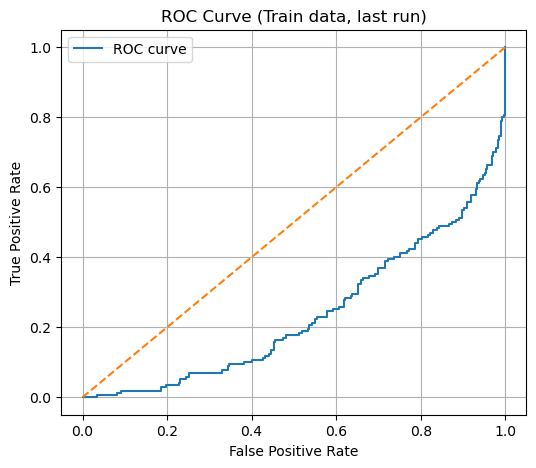

In [14]:
print("Avergae training metrics over 30 runs for unsupervised algorithm")
for metric, vals in metrics_uns.items():
    print(f"{metric}: {np.mean(vals):.4f}")

print("\nConfusion Matrix — TRAINING (last run)")
print(confusion_matrix(y_train, y_pred_train))

fpr, tpr, _ = roc_curve(y_train, distances_to_assigned)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Train data, last run)")
plt.grid(True)
plt.legend()
plt.show()

**C**

In [15]:
k = 2
closest_n = 30
M = 30

metrics_uns_test = {
    "test_acc_un_test": [], "test_prec_un_test": [], "test_rec_un_test": [],
    "test_f1_un_test": [], "test_auc_un_test": []
}

for run in range(M):
    best_centers = all_best_centers[run]
    best_labels = all_best_labels[run]
    
    cluster_to_label = {}
    for cluster_id in range(k):
        center = best_centers[cluster_id]
        cluster_points_idx = np.where(best_labels == cluster_id)[0]

        distances = np.linalg.norm(X_train[cluster_points_idx] - center, axis=1)
        closest_idx = cluster_points_idx[np.argsort(distances)[:closest_n]]

        majority_label = int(np.round(np.mean(y_train[closest_idx])))
        cluster_to_label[cluster_id] = majority_label

    y_pred_test = np.zeros(len(X_test), dtype=int)
    distances_to_assigned = np.zeros(len(X_test))

    for i, x in enumerate(X_test):
        dists = np.linalg.norm(best_centers - x, axis=1)
        closest_cluster = np.argmin(dists)
        y_pred_test[i] = cluster_to_label[closest_cluster]
        distances_to_assigned[i] = -dists[closest_cluster]

    metrics_uns_test["test_acc_un_test"].append(accuracy_score(y_test, y_pred_test))
    metrics_uns_test["test_prec_un_test"].append(precision_score(y_test, y_pred_test))
    metrics_uns_test["test_rec_un_test"].append(recall_score(y_test, y_pred_test))
    metrics_uns_test["test_f1_un_test"].append(f1_score(y_test, y_pred_test))
    metrics_uns_test["test_auc_un_test"].append(roc_auc_score(y_test, distances_to_assigned))

Average test metrics over 30 runs for the unsupervised algorithm
test_acc_un_test: 0.8889
test_prec_un_test: 1.0000
test_rec_un_test: 0.6984
test_f1_un_test: 0.8222
test_auc_un_test: 0.2266

Confusion Matrix — TEST DATA (last run)
[[72  0]
 [12 30]]


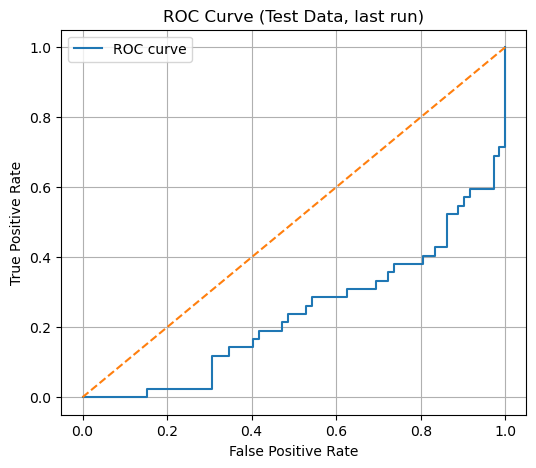

In [16]:
print("Average test metrics over 30 runs for the unsupervised algorithm")
for metric, vals in metrics_uns_test.items():
    print(f"{metric}: {np.mean(vals):.4f}")

print("\nConfusion Matrix — TEST DATA (last run)")
print(confusion_matrix(y_test, y_pred_test))

fpr, tpr, _ = roc_curve(y_test, distances_to_assigned)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Data, last run)")
plt.grid(True)
plt.legend()
plt.show()


#### (iv) Spectral Clustering

In [17]:
M = 30
n_clusters = 2
gamma = 1

metrics_spectr = {"accuracy_spectr": [], "precision_spectr": [], "recall_spectr": [], "f1_spectr": [], "auc_spectr": []}
metrics_spects = {"accuracy_spects": [], "precision_spects": [], "recall_spects": [], "f1_spects": [], "auc_spects": []}


for run in range(M):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=run
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    spec = SpectralClustering(
        n_clusters=n_clusters,
        affinity='rbf',
        gamma=gamma,
        assign_labels='discretize',
        random_state=run
    )

    y_train_cluster = spec.fit_predict(X_train_scaled)

    if accuracy_score(y_train, y_train_cluster) < 0.5:
        y_train_cluster = 1 - y_train_cluster

    cluster_to_label = {}
    for c in np.unique(y_train_cluster):
        cluster_indices = np.where(y_train_cluster == c)[0]
        majority_label = int(np.round(np.mean(y_train[cluster_indices])))
        cluster_to_label[c] = majority_label

    y_train_mapped = np.array([cluster_to_label[c] for c in y_train_cluster])

    metrics_spectr["accuracy_spectr"].append(accuracy_score(y_train, y_train_mapped))
    metrics_spectr["precision_spectr"].append(precision_score(y_train, y_train_mapped, zero_division=0))
    metrics_spectr["recall_spectr"].append(recall_score(y_train, y_train_mapped, zero_division=0))
    metrics_spectr["f1_spectr"].append(f1_score(y_train, y_train_mapped, zero_division=0))
    metrics_spectr["auc_spectr"].append(roc_auc_score(y_train, y_train_mapped))

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train_scaled, y_train_mapped)
    y_pred_test = knn.predict(X_test_scaled)

    distances_to_nn, _ = knn.kneighbors(X_test_scaled, n_neighbors=1)
    y_score_test = -distances_to_nn.ravel()

    metrics_spects["accuracy_spects"].append(accuracy_score(y_test, y_pred_test))
    metrics_spects["precision_spects"].append(precision_score(y_test, y_pred_test, zero_division=0))
    metrics_spects["recall_spects"].append(recall_score(y_test, y_pred_test, zero_division=0))
    metrics_spects["f1_spects"].append(f1_score(y_test, y_pred_test, zero_division=0))
    metrics_spects["auc_spects"].append(roc_auc_score(y_test, y_score_test))

Spectral Clustering — Average Training metrics over 30 runs 
accuracy_spectr: 0.6323
precision_spectr: 0.5282
recall_spectr: 0.0176
f1_spectr: 0.0330
auc_spectr: 0.5083

Confusion Matrix — Train (last run)
[[285   0]
 [170   0]]


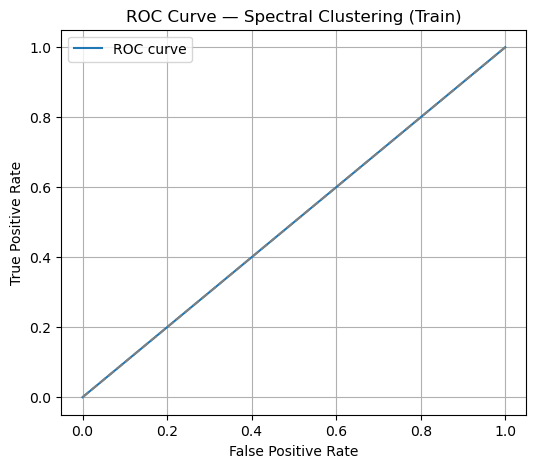

In [18]:
print("Spectral Clustering — Average Training metrics over 30 runs ")
for metric, vals in metrics_spectr.items():
    print(f"{metric}: {np.mean(vals):.4f}")

print("\nConfusion Matrix — Train (last run)")
print(confusion_matrix(y_train, y_train_mapped))
fpr, tpr, _ = roc_curve(y_train, y_train_mapped)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Spectral Clustering (Train)")
plt.grid(True)
plt.legend()
plt.show()

Spectral Clustering — TAverage test metrics over 30 runs
accuracy_spects: 0.6330
precision_spects: 0.1000
recall_spects: 0.0040
f1_spects: 0.0075
auc_spects: 0.2430

Confusion Matrix — Test (last run)
[[72  0]
 [42  0]]


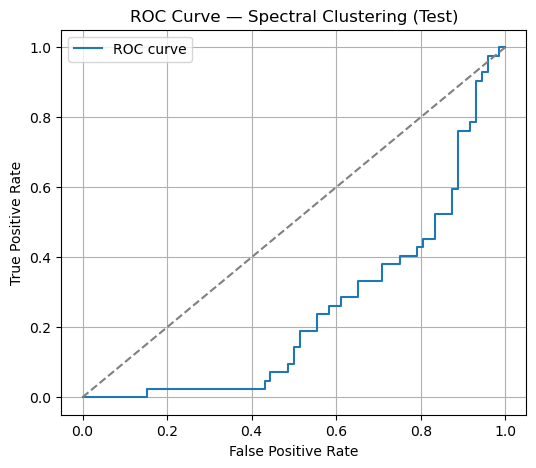

In [19]:
print("Spectral Clustering — TAverage test metrics over 30 runs")
for metric, vals in metrics_spects.items():
    print(f"{metric}: {np.mean(vals):.4f}")

print("\nConfusion Matrix — Test (last run)")
print(confusion_matrix(y_test, y_pred_test))
fpr, tpr, _ = roc_curve(y_test, y_score_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Spectral Clustering (Test)")
plt.grid(True)
plt.legend()
plt.show()


#### (iv) Compare

The‍‌‍‍‌‍‌‍‍‌ results provide strong evidence that the performance hierarchy of the three learning paradigms is as expected. Supervised learning that relies on full labeled data achieves high test accuracy (≈0.96), a good precision/recall balance, and impressive AUC (≈0.99) overall. Besides, the supervised classifier is not only accurate but also stable across runs. 
The  semi-supervised method which only uses half of the labels manages to perform quite good as well and actually attains slightly higher test accuracy (≈0.98) and almost perfect test AUC (≈0.999) as well. This can be interpreted as the unlabeled data offering a more helpful resource for generalization. 
On the other hand, the unsupervised approach (clustering) is far from being good especially on training data where accuracy is low, recall is poor, and AUC is very low, and this is in line with the expectation that clustering cannot separate classes without labels in a reliable way. Even though the unsupervised test accuracy seems to be at a reasonably high level (≈0.888), it is actually a trick as the model almost entirely predicts negatives (precision = 1.0 but recall ≈0.70), which is evidenced by its very low AUC (~0.226). 
In summary, the outcomes are in line with the theoretical framework: supervised > semi-supervised >> unsupervised with the important observation that semi-supervised learning can almost reach or even occasionally surpass fully supervised test performance when there is a strong underlying structure in the ‍‌‍‍‌‍‌‍‍‌data. 



## 2. Active Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set

In [20]:
data = pd.read_csv("../data/data_banknote_authentication.txt", header=None)

data.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

train_data, test_data = train_test_split(data, test_size=472, random_state=42, shuffle=True, stratify=data['class'])

X_train = train_data.drop('class', axis=1).values
y_train = train_data['class'].values

X_test = test_data.drop('class', axis=1).values
y_test = test_data['class'].values

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (900, 4) (900,)
Test set: (472, 4) (472,)


### (b) Repeat each of the following two procedures 50 times

#### (i) Passive

In [21]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)


M = 50
pool_sizes = np.arange(10, 901, 10)
passive_errors = np.zeros((M, len(pool_sizes)))

param_grid_passive = {"C": np.logspace(-3, 3, 10)} 

for run_passive in range(M):
    X_train_run, X_test_run, y_train_run, y_test_run = train_test_split(
        X, y, test_size=472, random_state=run_passive, stratify=y
    )

    scaler_passive = StandardScaler()
    X_train_s = scaler_passive.fit_transform(X_train_run)
    X_test_s = scaler_passive.transform(X_test_run)

    pool_indices_passive = np.arange(len(X_train_s))
    np.random.shuffle(pool_indices_passive)

    for i, size in enumerate(pool_sizes):
        idx_subset = pool_indices_passive[:size]
        X_pool_passive = X_train_s[idx_subset]
        y_pool_passive = y_train_run[idx_subset]

        if len(np.unique(y_pool_passive)) < 2:
            np.random.shuffle(pool_indices_passive)
            idx_subset = pool_indices_passive[:size]
            X_pool_passive = X_train_s[idx_subset]
            y_pool_passive = y_train_run[idx_subset]

        svm_passive = LinearSVC(penalty="l1", dual=False, max_iter=5000)

        passive_model = GridSearchCV(
            svm_passive,
            param_grid_passive,
            cv=StratifiedKFold(n_splits=5),
            n_jobs=-1
        )

        passive_model.fit(X_pool_passive, y_pool_passive)

        y_pred_passive = passive_model.predict(X_test_s)
        passive_errors[run_passive, i] = 1 - accuracy_score(y_test_run, y_pred_passive)


print("Passive errors shape:", passive_errors.shape)

Passive errors shape: (50, 90)


#### (ii) Active

In [22]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

scaler = StandardScaler()
X_train_scaled_active = scaler.fit_transform(X_train)
X_test_scaled_active = scaler.transform(X_test)

M = 50
pool_sizes = np.arange(10, 901, 10)
active_errors = np.zeros((M, len(pool_sizes)))

C_values_active = np.logspace(-3, 3, 10)


for run in range(M):
    idx_active = np.random.permutation(len(X_train_scaled_active))
    X_remaining_active = X_train_scaled_active[idx_active]
    y_remaining_active = y_train[idx_active]

    while True:
        pool_idx_active = np.random.choice(len(X_remaining_active), 10, replace=False)
        X_pool_active = X_remaining_active[pool_idx_active]
        y_pool_active = y_remaining_active[pool_idx_active]

        if len(np.unique(y_pool_active)) > 1:
            break

    X_remaining_active = np.delete(X_remaining_active, pool_idx_active, axis=0)
    y_remaining_active = np.delete(y_remaining_active, pool_idx_active, axis=0)

    for i, size_active in enumerate(pool_sizes):
        svc_active = LinearSVC(penalty='l1', dual=False, max_iter=5000)
        active_model = GridSearchCV(
            svc_active,
            param_grid={'C': C_values_active},
            cv=StratifiedKFold(n_splits= 5),
            n_jobs=-1
        )

        active_model.fit(X_pool_active, y_pool_active)

        y_pred_active = active_model.predict(X_test_scaled_active)
        active_errors[run, i] = np.mean(y_pred_active != y_test)

        if len(X_remaining_active) == 0:
            break

        dists = active_model.best_estimator_.decision_function(X_remaining_active)
        abs_dists = np.abs(dists)

        k = min(10, len(X_remaining_active))
        closest_idx = np.argsort(abs_dists)[:k]

        X_pool_active = np.vstack([X_pool_active, X_remaining_active[closest_idx]])
        y_pool_active = np.concatenate([y_pool_active, y_remaining_active[closest_idx]])

        X_remaining_active = np.delete(X_remaining_active, closest_idx, axis=0)
        y_remaining_active = np.delete(y_remaining_active, closest_idx, axis=0)

print("Shape of active learning errors:", active_errors.shape)

Shape of active learning errors: (50, 90)


### (c) Average the 50 test errors

Samples   Passive learning average  Active learning average
10              0.1564                   0.1590
20              0.0847                   0.0751
30              0.0691                   0.0386
40              0.0679                   0.0289
50              0.0579                   0.0166
60              0.0561                   0.0126
70              0.0516                   0.0167
80              0.0447                   0.0156
90              0.0446                   0.0117
100              0.0447                   0.0102
110              0.0436                   0.0095
120              0.0433                   0.0096
130              0.0447                   0.0098
140              0.0444                   0.0091
150              0.0445                   0.0097
160              0.0444                   0.0100
170              0.0447                   0.0103
180              0.0444                   0.0104
190              0.0440                   0.0103
200              0

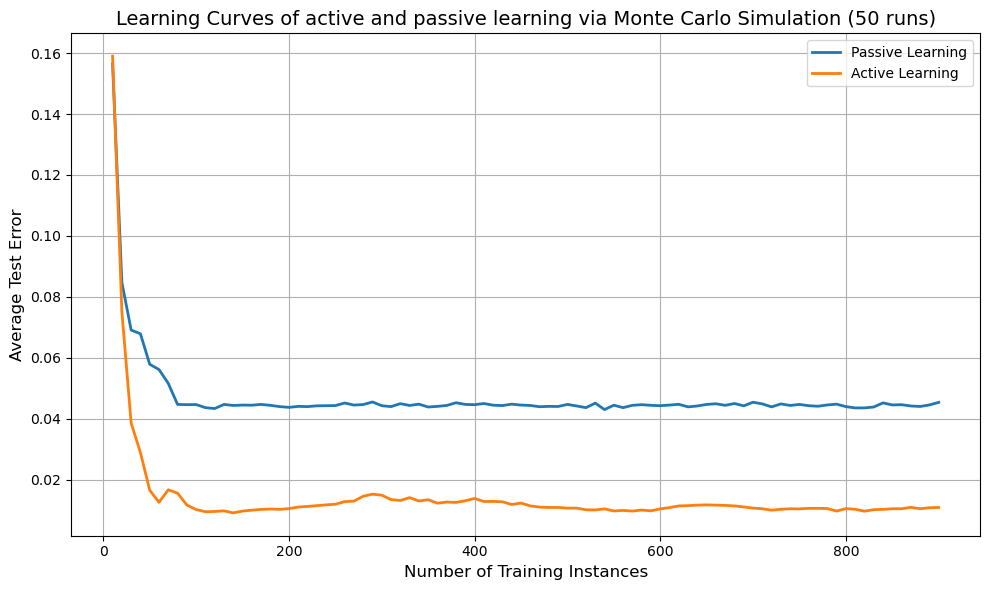

In [23]:
avg_passive = passive_errors.mean(axis=0)   
avg_active = active_errors.mean(axis=0)     

print("Samples   Passive learning average  Active learning average")
for i, size in enumerate(pool_sizes):
    print(f"{size}              {avg_passive[i]:.4f}                   {avg_active[i]:.4f}")

plt.figure(figsize=(10, 6))

plt.plot(pool_sizes, avg_passive, label="Passive Learning", linewidth=2)
plt.plot(pool_sizes, avg_active, label="Active Learning", linewidth=2)

plt.xlabel("Number of Training Instances", fontsize=12)
plt.ylabel("Average Test Error", fontsize=12)
plt.title("Learning Curves of active and passive learning via Monte Carlo Simulation (50 runs)", fontsize=14)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The learning curves reveal a clear difference between passive learning and active learning. When the training sets are very small (10–50 samples), active learning is visibly superior, thus it obtains much lower test error since it selectively queries the most informative points near the SVM decision boundary. Passive learning initially has higher error because the randomly chosen subsets may have redundancies or less informative samples. 

After the increase of training size, the benefit of active learning slowly fades, and both methods get close to each other, and the curve starts flattening. The passive learning error beyond about 200–300 samples is still changing slightly and averaging ~0.044, whereas active learning keeps a significantly lower error of ~0.010–0.015. 

In essence, the experiments convey that active learning is hugely more economical because it reaches almost the same level of accuracy with a significantly smaller number of labeled samples as compared to passive ‍‌learning. 